In [70]:
import pyspark
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf,lit

sns.set(style="white", color_codes=True)
sns.set_context(rc={"font.family":'sans',"font.size":24,"axes.titlesize":24,"axes.labelsize":24})   


# import matplotlib and allow it to plot inline
import matplotlib.pyplot as plt
%matplotlib inline

# seaborn can generate several warnings, we ignore them
import warnings 
warnings.filterwarnings("ignore")

from pyspark.sql import SQLContext
sc = pyspark.SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

# Queries:
- the percentage of canceled flights per day, throughout the entire data set
- weekly percentages of delays that are due to weather, throughout the entire data set 
- the percentage of flights belonging to a given "distance group" that were able to halve their departure delays by the time they arrived at their destinations. Distance groups assort flights by their total distance in miles. Flights with distances that are less than 200 miles belong in group 1, flights with distances that are between 200 and 399 miles belong in group 2, flights with distances that are between 400 and 599 miles belong in group 3, and so on. The last group contains flights whose distances are between 2400 and 2599 miles.
- a weekly "penalty" score for each airport that depends on both the its incoming and outgoing flights. The score adds 0.5 for each incoming flight that is more than 15 minutes late, and 1 for each outgoing flight that is more than 15 minutes late.


# "The percentage of canceled flights per day, throughout the entire data set"
## Sql version

In [47]:
def getCancelledPercentage(file):
    d = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true')\
    .load(file)
    
    d_ymdc= d.select(d["Year"],d["Month"],d["DayofMonth"],d["Cancelled"])
    
    d_cancelled = d_ymdc.filter(d["Cancelled"]==1) \
        .groupBy(d["Year"],d["Month"],d["DayofMonth"]) \
        .count().withColumnRenamed("count","cancelled")
    
    d_total = d_ymdc \
        .groupBy(d["Year"],d["Month"],d["DayofMonth"]) \
        .count().withColumnRenamed("count","total")
    
    res = d_cancelled.join(d_total, on=[d_cancelled.Year == d_total.Year, d_cancelled.Month == d_total.Month,d_cancelled.DayofMonth == d_total.DayofMonth]) \
        .select(d_cancelled.Year,d_cancelled.Month,d_cancelled.DayofMonth,d_cancelled["cancelled"],d_total["total"])
    
    return res.withColumn("percentageCancelled", (res.cancelled/res.total))\
        .drop("cancelled","total")\
        .orderBy("Year","Month","DayofMonth")
        

res1=[getCancelledPercentage("BDdata/"+str(i)+".csv") for i in range(1994,2009)]


In [48]:
def saveUnited(filename, res1):
    res=res1[0]
    for el in res1[1:]:
        res=res.union(el)
    res.coalesce(1).write.csv(filename,header=True)

saveUnited("./query1.csv",res1)

## MapReduce version

In [41]:
def getPercentage(year):
    ds = sc.textFile('./BDdata/'+year+'.csv')
    dsplitted = ds.map(lambda line : line.split(","))

    head = dsplitted.take(1)[0]
    dsfiltered = dsplitted.filter(lambda x : x != head)

    dmapped = dsfiltered.map(lambda x : (tuple([int(el) for el in x[0:3]]),int(x[21])))

    date_cancelled = dmapped.reduceByKey(lambda a, b : a+b)
    total_per_date = dmapped.map(lambda x: (x[0],1)).reduceByKey(lambda a, b : a+b)

    results=date_cancelled.join(total_per_date).map(lambda x : (x[0], x[1][0]/x[1][1]))
    return results


In [67]:
res2 = [getPercentage(str(i)).collect() for i in range(1994,2009)]

## Extra query: Weekly percentages of flights cancelled that are due to weather, throughout the entire data set 

We load the data from the file:

In [23]:
week = udf(lambda *x : datetime(x[0],x[1],x[2]).isocalendar()[1], IntegerType())

In [ ]:

def getWeatherPercentage(year, newYearFirstWeek=None):
    d = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true')\
        .load('BDdata/'+year+'.csv')
    dr = d.filter(d["Cancelled"]=='1')\
        .select(d["Year"],d["Month"],d["DayofMonth"],d["CancellationCode"])

    d_cancelled_weather = dr.filter(d["CancellationCode"]=='B')

    d2 = dr.groupBy(d["Year"],d["Month"],d["DayofMonth"])\
        .count()\
        .withColumnRenamed("count","cancelled")
    
    d3 = d_cancelled_weather.groupBy(d["Year"],d["Month"],d["DayofMonth"])\
        .count()\
        .withColumnRenamed("count","weather")
    
    d4 = d2.join(d3, on=[d2["Year"]==d3["Year"],d2["Month"]==d3["Month"],d2["DayofMonth"]==d3["DayofMonth"]])\
        .select(d2["Year"],d2["Month"],d2["DayofMonth"],d2["cancelled"],d3["weather"])\
        .orderBy(d2["Year"],d2["Month"],d2["DayofMonth"])
        
    d5 = d4.withColumn("week", week(d4["Year"],d4["Month"],d4["DayofMonth"]))
    
    newYearFirstWeek1 = d5.filter(d5["week"]==1).filter(d5["Month"]=="12")
    if newYearFirstWeek is not None:
        d5 = d5.union(newYearFirstWeek)
    d5a = d5.filter((d5["week"]!=1) | (d5["Month"]!="12")).groupBy("Year","week")\
        .agg({"cancelled":"sum","weather":"sum"})
    d6 = d5a.withColumn("percentage",d5a["sum(weather)"]/d5a["sum(cancelled)"])\
        .select(d5a["Year"],d5a["week"],"percentage")\
        .sort("Year","week")
    return (d6, newYearFirstWeek1)

In [37]:
newYearFirstWeek = None
res=[]
for i in range(1994, 2009):
    result, newYearFirstWeek = getWeatherPercentage(str(i), newYearFirstWeek)
    res.append(result)


+----+-----+----------+-------+
|Year|Month|DayofMonth|weather|
+----+-----+----------+-------+
+----+-----+----------+-------+

+----+-----+----------+-------+
|Year|Month|DayofMonth|weather|
+----+-----+----------+-------+
+----+-----+----------+-------+

+----+-----+----------+-------+
|Year|Month|DayofMonth|weather|
+----+-----+----------+-------+
+----+-----+----------+-------+

+----+-----+----------+-------+
|Year|Month|DayofMonth|weather|
+----+-----+----------+-------+
+----+-----+----------+-------+

+----+-----+----------+-------+
|Year|Month|DayofMonth|weather|
+----+-----+----------+-------+
+----+-----+----------+-------+

+----+-----+----------+-------+
|Year|Month|DayofMonth|weather|
+----+-----+----------+-------+
+----+-----+----------+-------+

+----+-----+----------+-------+
|Year|Month|DayofMonth|weather|
+----+-----+----------+-------+
+----+-----+----------+-------+

+----+-----+----------+-------+
|Year|Month|DayofMonth|weather|
+----+-----+----------+-------+
+

In [44]:
res1=res[0]
for el in res[1:]:
    res1=res1.union(el)
    
res1.coalesce(1).write.csv("./query2.csv",header=True)

# Weekly percentages of delays that are due to weather, throughout the entire data set 

In [8]:
def getWeatherDelayPercentage(year,oldYearFirstWeek=None):
    d = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true')\
        .load('BDdata/'+year+'.csv')

    d1 = d.where("ArrDelay >= 0").select(d["Year"],d["Month"],d["DayofMonth"],d["ArrDelay"],d["WeatherDelay"])
    if d1.where("WeatherDelay == 'NA'").count() > 0:
        d1= d1.where("WeatherDelay != 'NA'")

    d3 = d1.groupBy(d["Year"],d["Month"],d["DayofMonth"]).agg({"ArrDelay":"sum","WeatherDelay":"sum"})
    
    week = udf(lambda *x : datetime(x[0],x[1],x[2]).isocalendar()[1], IntegerType())

    d4 = d3.withColumn("week", week(d3["Year"],d3["Month"],d3["DayofMonth"]))

    newYearFirstWeek = d4.filter(d4["week"]==1).filter(d4["Month"]=="12")
    d5a = d4.filter((d4["week"]!=1) | (d4["Month"]!="12"))
    
    if(oldYearFirstWeek is not None):
        d5a = d5a.union(oldYearFirstWeek)
        
    d5b = d5a.drop("Year").groupBy("week")\
            .agg({"sum(WeatherDelay)":"sum","sum(ArrDelay)":"sum"})
    d6 = d5b.withColumn("percentage",d5b["sum(sum(WeatherDelay))"]/d5b["sum(sum(ArrDelay))"])\
            .withColumn("Year",lit(year))\
            .drop("sum(sum(WeatherDelay))","sum(sum(ArrDelay))")\
            .sort("Year","week")
    
    return (d6,newYearFirstWeek)

d7, x = getWeatherDelayPercentage("2004")
d7.show()

+----+--------------------+----+
|week|          percentage|Year|
+----+--------------------+----+
|   1| 0.07434515676522563|2004|
|   2| 0.06307909121084979|2004|
|   3| 0.06906457349675801|2004|
|   4| 0.06112653802823575|2004|
|   5| 0.09106793076338827|2004|
|   6| 0.07341102967679923|2004|
|   7| 0.05757752477390909|2004|
|   8| 0.03147182026203678|2004|
|   9| 0.06339412919870108|2004|
|  10|0.052794145119839236|2004|
|  11|0.025798587549322675|2004|
|  12| 0.04267350976706616|2004|
|  13|0.016706971577044198|2004|
|  14|0.029161947023824342|2004|
|  15| 0.02935286463035731|2004|
|  16| 0.05104257324425239|2004|
|  17| 0.04180623220286374|2004|
|  18| 0.04801365267544427|2004|
|  19| 0.04985891227714397|2004|
|  20| 0.07074660352697981|2004|
+----+--------------------+----+
only showing top 20 rows



In [51]:
newYearFirstWeek = None
res=[]
for i in range(1994, 2009):
    result, newYearFirstWeek = getWeatherPercentage(str(i), newYearFirstWeek)
    res.append(result)

res1=res[0]
for el in res[1:]:
    res1=res1.union(el)
    
res1.coalesce(1).write.csv("./query3.csv",header=True)

+----+-----+----------+-------+
|Year|Month|DayofMonth|weather|
+----+-----+----------+-------+
+----+-----+----------+-------+

+----+-----+----------+-------+
|Year|Month|DayofMonth|weather|
+----+-----+----------+-------+
+----+-----+----------+-------+

+----+-----+----------+-------+
|Year|Month|DayofMonth|weather|
+----+-----+----------+-------+
+----+-----+----------+-------+

+----+-----+----------+-------+
|Year|Month|DayofMonth|weather|
+----+-----+----------+-------+
+----+-----+----------+-------+

+----+-----+----------+-------+
|Year|Month|DayofMonth|weather|
+----+-----+----------+-------+
+----+-----+----------+-------+

+----+-----+----------+-------+
|Year|Month|DayofMonth|weather|
+----+-----+----------+-------+
+----+-----+----------+-------+

+----+-----+----------+-------+
|Year|Month|DayofMonth|weather|
+----+-----+----------+-------+
+----+-----+----------+-------+

+----+-----+----------+-------+
|Year|Month|DayofMonth|weather|
+----+-----+----------+-------+
+

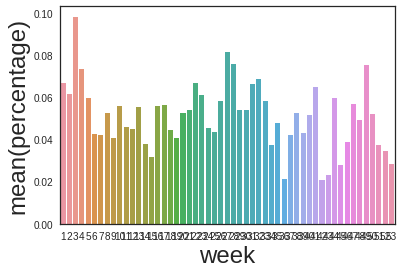

In [12]:
ax = sns.barplot(x="week", y="percentage", data=d7.toPandas())

## The percentage of flights belonging to a given "distance group" that were able to halve their departure delays by the time they arrived at their destinations. 

Distance groups assort flights by their total distance in miles. Flights with distances that are less than 200 miles belong in group 1, flights with distances that are between 200 and 399 miles belong in group 2, flights with distances that are between 400 and 599 miles belong in group 3, and so on. The last group contains flights whose distances are between 2400 and 2599 miles.

In [64]:
d = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true')\
        .load('BDdata/2005.csv')
d1 = d.where(d["Cancelled"]==0)\
    .where(d["DepDelay"] != "NA")\
    .where(d["ArrDelay"] != "NA")\
    .select(d["DepDelay"],d["ArrDelay"],d["Distance"])

distanceGroup = udf(lambda x : x//200+1,IntegerType())
d2 = d1.withColumn("DistanceGroup",distanceGroup(d1["Distance"]))\
    .drop(d1["Distance"])

d3 = d2.filter(d2["DepDelay"]>=2*d2["ArrDelay"])\
    .groupBy(d2.DistanceGroup).agg({"*":"count"})

d4 = d2.groupBy(d2.DistanceGroup).agg({"*":"count"})

d5 = d4.join(d3,on=[d3.DistanceGroup==d4.DistanceGroup])\
    .withColumn("percentage", d3["count(1)"]/d4["count(1)"])\
    .drop("count(1)")\
    .select(d4.DistanceGroup,"percentage").sort("DistanceGroup")

In [68]:
d5.show()

+-------------+------------------+
|DistanceGroup|        percentage|
+-------------+------------------+
|            1|0.5876224923306915|
|            2|0.5757068598210482|
|            3| 0.561471897762626|
|            4|0.5688015900802174|
|            5|0.5605372543402206|
|            6|0.5436613265874061|
|            7|0.5574551778009225|
|            8|0.5512521127105566|
|            9|0.5605423769579989|
|           10| 0.544119338250998|
|           11|0.5433981336521986|
|           12|0.5830452613710987|
|           13|0.5312673762031185|
|           14|0.5913933570085649|
|           15|0.5382224984462399|
|           16|               0.3|
|           17|0.6046052631578948|
|           18|0.4482758620689655|
|           19|0.5956112852664577|
|           20|0.5176282051282052|
+-------------+------------------+
only showing top 20 rows



In [82]:

def getPercentageFastDistanceGroup(init,end):

    d = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true')\
        .load('BDdata/'+str(init)+'.csv')
    for i in range(init+1,end+1):
        d.union(sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true')\
            .load('BDdata/'+str(i)+'.csv'))
    
    d1 = d.where(d["Cancelled"]==0)\
        .where(d["DepDelay"] != "NA")\
        .where(d["ArrDelay"] != "NA")\
        .select(d["DepDelay"],d["ArrDelay"],d["Distance"])

    distanceGroup = udf(lambda x : x//200+1,IntegerType())
    d2 = d1.withColumn("DistanceGroup",distanceGroup(d1["Distance"]))\
        .drop(d1["Distance"])
    
    d3 = d2.filter(d2["DepDelay"]>=2*d2["ArrDelay"])\
        .groupBy(d2.DistanceGroup).agg({"*":"count"})

    d4 = d2.groupBy(d2.DistanceGroup).agg({"*":"count"})

    d5 = d4.join(d3,on=[d3.DistanceGroup==d4.DistanceGroup])\
        .withColumn("percentage", d3["count(1)"]/d4["count(1)"])\
        .drop("count(1)")\
        .select(d4.DistanceGroup,"percentage").sort("DistanceGroup")
    return d5
res = getPercentageFastDistanceGroup(1994,2008)

In [83]:
res.coalesce(1).write.csv("./query4.csv",header=True)

## A weekly "penalty" score for each airport that depends on both the its incoming and outgoing flights. 
The score adds 0.5 for each incoming flight that is more than 15 minutes late, and 1 for each outgoing flight that is more than 15 minutes late.

In [71]:
d = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true')\
    .load('BDdata/2003.csv')

d1 = d.select(d["Origin"],d["Dest"],d["ArrDelay"])\
    .filter('ArrDelay > 15')
d2 = d1.withColumn("in", lit(0.5))\
    .withColumn("out",lit(1))\
    .select("Origin","Dest","in","out")
d3 = d2.groupBy(d2["Origin"])\
            .agg({"out":"sum"})\
    .join(d2.groupBy(d2["Dest"])\
            .agg({"in":"sum"}), on=[d2["Dest"]==d2["Origin"]])

In [72]:
d4 = d3.withColumn("Penalty", d3["sum(out)"]+d3["sum(in)"])\
    .drop("Dest")\
    .withColumnRenamed("Origin","Airport")\
    .withColumnRenamed("sum(out)","OutgoingPenalty")\
    .withColumnRenamed("sum(in)","IngoingPenalty").sort("Penalty")\
    .sort("Airport")
d4.show()


+-------+---------------+--------------+--------+
|Airport|OutgoingPenalty|IngoingPenalty| Penalty|
+-------+---------------+--------------+--------+
|    ABE|            607|         329.0|   936.0|
|    ABI|            211|         188.5|   399.5|
|    ABQ|           3537|        2239.5|  5776.5|
|    ABY|            249|         148.0|   397.0|
|    ACK|             41|          32.0|    73.0|
|    ACT|            159|         138.0|   297.0|
|    ACV|            600|         211.5|   811.5|
|    ACY|             12|          11.0|    23.0|
|    ADK|             19|          11.5|    30.5|
|    ADQ|            140|          66.0|   206.0|
|    AEX|            419|         243.5|   662.5|
|    AGS|            925|         529.5|  1454.5|
|    AKN|             60|          30.0|    90.0|
|    ALB|           3058|        1668.0|  4726.0|
|    AMA|            875|         661.5|  1536.5|
|    ANC|           3224|        1893.5|  5117.5|
|    ATL|          77980|       34184.0|112164.0|


In [5]:
p4 = d4.toPandas()

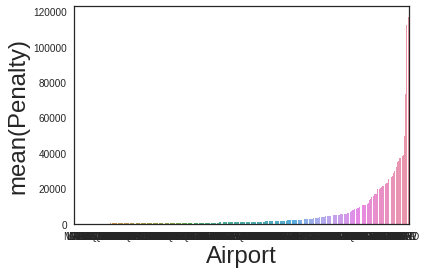

In [7]:
ax = sns.barplot(x="Airport", y="Penalty", data=p4)

In [85]:
def getAirportPenalty(init,end):
    d = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true')\
        .load('BDdata/'+str(init)+'.csv')
    for i in range(init+1,end+1):
        d.union(sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true')\
        .load('BDdata/'+str(i)+'.csv'))
    d1 = d.select(d["Origin"],d["Dest"],d["ArrDelay"]).filter('ArrDelay > 15')
    d2 = d1.withColumn("in", lit(0.5)).withColumn("out",lit(1)).select("Origin","Dest","in","out")
    d3 = d2.groupBy(d2["Origin"])\
        .agg({"out":"sum"})\
        .join(d2.groupBy(d2["Dest"]).agg({"in":"sum"}), on=[d2["Dest"]==d2["Origin"]])
    d4 = d3.withColumn("Penalty", d3["sum(out)"]+d3["sum(in)"])\
        .drop("Dest")\
        .withColumnRenamed("Origin","Airport")\
        .withColumnRenamed("sum(out)","OutgoingPenalty")\
        .withColumnRenamed("sum(in)","IngoingPenalty").sort("Penalty")
    return d4

getAirportPenalty(1994,2008).coalesce(1).write.csv("./query5.csv",header=True)